<a href="https://colab.research.google.com/github/Deekshapoornashri25/python5731/blob/master/In_Class_exercises_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In class exercise 10

The purpose of the exercise is to practice different machine learning algorithms for text clustering
Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

Apply the listed clustering methods to the dataset:

K means, 
DBSCAN,
Hierarchical clustering. 

You can refer to of the codes from  the follwing link below. 
https://www.kaggle.com/karthik3890/text-clustering 
    

In [12]:

import pandas as pd
import gensim
df=pd.read_csv("/content/Amazon_Unlocked_Mobile.csv")
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from textblob import Word
nltk.download('wordnet')
from nltk.stem import PorterStemmer
st = PorterStemmer()
df = df[df['Reviews'].notnull()]
stop = stopwords.words('english')
df['after_punct_less'] = df['Reviews'].str.replace('[^\w\s].#','')
df['after_rm_stopwords'] =df['after_punct_less'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['after_numerics']=df['after_rm_stopwords'].str.replace('[0-9]','')
df['after_lowercasing'] =df['after_numerics'].apply(lambda x: " ".join(x.lower() for x in x.split()))

df['after_stemming']=df['after_lowercasing'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
df['cleaned_text'] = df['after_stemming'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
df['cleaned_text'].head()

0    i feel lucki found use (phone u & use hard all...
1    nice phone, nice grade pantach revue. veri cle...
2                                            veri plea
3      it work good goe slow sometim good phone i love
4    great phone replac lost phone. the thing volum...
Name: cleaned_text, dtype: object

In [14]:
df_1=(df.sample(n=4000)).reset_index()

In [15]:

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(df_1['cleaned_text'].values)
tfidf.shape

(4000, 7158)

In [16]:
from sklearn.cluster import KMeans
model_tf = KMeans(n_clusters = 5, n_jobs = -1,random_state=99)
model_tf.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=99, tol=0.0001, verbose=0)

In [17]:
labels_tf = model_tf.labels_
cluster_center_tf=model_tf.cluster_centers_

In [18]:
terms1 = tfidf_vect.get_feature_names()
terms1[1:5]
df1 = df_1
df1['Tfidf Clus Label'] = model_tf.labels_
df1.head(5)

,index,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,after_punct_less,after_rm_stopwords,after_numerics,after_lowercasing,after_stemming,cleaned_text,Tfidf Clus Label
0,56326,Apple iPhone 6 Plus 128GB Factory Unlocked GSM...,NaN,648.00,5,The large screen with the accesibilites option...,0.0,The large screen with the accesibilites option...,The large screen accesibilites options help mo...,The large screen accesibilites options help mo...,the large screen accesibilites options help mo...,the larg screen accesibilit option help mom re...,the larg screen accesibilit option help mom re...,1
1,304531,Samsung Convoy 2 SCH-U660 Military Standard Ru...,Samsung,99.99,5,My wife's 5th phone! Cheap and functional...al...,0.0,My wife's 5th phone! Cheap and functional...al...,My wife's 5th phone! Cheap functional...all re...,My wife's th phone! Cheap functional...all req...,my wife's th phone! cheap functional...all req...,my wife' th phone! cheap functional...al requi...,my wife' th phone! cheap functional...al requi...,1
2,34779,Apple iPhone 5c 8GB (Yellow) - Verizon Wireless,Apple,179.99,5,Very fast shipping. Product like description,1.0,Very fast shipping. Product like description,Very fast shipping. Product like description,Very fast shipping. Product like description,very fast shipping. product like description,veri fast shipping. product like descript,veri fast shipping. product like descript,1
3,146649,BLU Studio C 5+5 LTE Smartphone - GSM Unlocked...,BLU,99.00,5,"All we have acquired smartphone BLU brand, we ...",0.0,"All we have acquired smartphone BLU brand, we ...","All acquired smartphone BLU brand, know excell...","All acquired smartphone BLU brand, know excell...","all acquired smartphone blu brand, know excell...","all acquir smartphon blu brand, know excel dev...","all acquir smartphon blu brand, know excel dev...",1
4,40895,Apple iPhone 5s 16GB (Space Gray) - Verizon Wi...,Apple,149.99,5,Great condition! Arrived with charger and no m...,0.0,Great condition! Arrived with charger and no m...,Great condition! Arrived charger marks scratch...,Great condition! Arrived charger marks scratch...,great condition! arrived charger marks scratch...,great condition! arriv charger mark scratches....,great condition! arriv charger mark scratches....,1


In [19]:
df1.groupby(['Tfidf Clus Label'])['cleaned_text'].count()

Tfidf Clus Label
0     124
1    3473
2     189
3      55
4     159
Name: cleaned_text, dtype: int64

In [20]:
print("Top terms per cluster:")
order_centroids = model_tf.cluster_centers_.argsort()[:, ::-1]
for i in range(1,5):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :5]:
        print(' %s' % terms1[ind], end='')
        print()

Top terms per cluster:
Cluster 1: phone
 great
 it
 work
 the
Cluster 2: good
 veri
 phone
 product
 it
Cluster 3: excelent
 producto
 telefono
 recomiendo
 lo
Cluster 4: love
 it
 phone
 great
 wife


In [21]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import gensim

In [22]:
i=0
list_of_sent=[]
for sent in df_1['cleaned_text'].values:
    list_of_sent.append(sent.split())

In [23]:
w2v_model=gensim.models.Word2Vec(list_of_sent,size=100, workers=4)
import numpy as np
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(4000, 100)

In [24]:
# Computing 200th Nearest neighbour distance
minPts = 2 * 100
# Lower bound function copied from -> https://gist.github.com/m00nlight/0f9306b4d4e61ba0195f
def lower_bound(nums, target): # This function return the number in the array just greater than or equal to itself.
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute200thnearestneighbour(x, data): # Returns the distance of 200th nearest neighbour.
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) # computing distances.
        if(len(dists) == 200 and dists[199] > dist): # If distance is larger than current largest distance found.
            l = int(lower_bound(dists, dist)) # Using the lower bound function to get the right position.
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[199]

In [25]:
twohundrethneigh = []
for val in sent_vectors[:1500]:
    twohundrethneigh.append( compute200thnearestneighbour(val, sent_vectors[:1500]) )
twohundrethneigh.sort()

In [ ]:
mob_vectors.shape

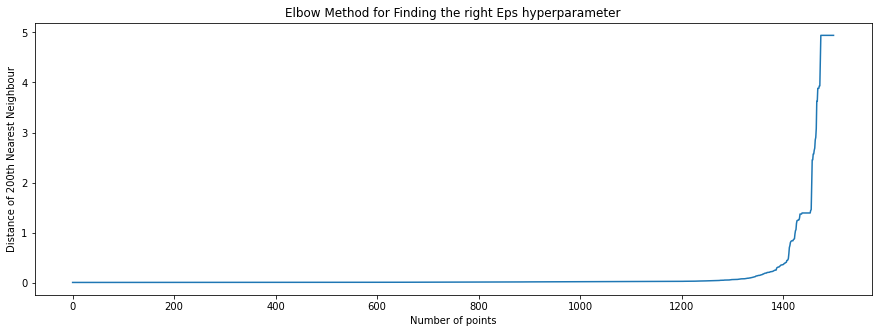

In [26]:
plt.figure(figsize=(15,5))
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [28]:
model = DBSCAN(eps = 8, min_samples = minPts, n_jobs=-2)
model.fit(sent_vectors)
df_1['AVG-W2V Clus Label'] = model.labels_
df_1.head(2)


,index,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,after_punct_less,after_rm_stopwords,after_numerics,after_lowercasing,after_stemming,cleaned_text,Tfidf Clus Label,AVG-W2V Clus Label
0,56326,Apple iPhone 6 Plus 128GB Factory Unlocked GSM...,NaN,648.00,5,The large screen with the accesibilites option...,0.0,The large screen with the accesibilites option...,The large screen accesibilites options help mo...,The large screen accesibilites options help mo...,the large screen accesibilites options help mo...,the larg screen accesibilit option help mom re...,the larg screen accesibilit option help mom re...,1,0
1,304531,Samsung Convoy 2 SCH-U660 Military Standard Ru...,Samsung,99.99,5,My wife's 5th phone! Cheap and functional...al...,0.0,My wife's 5th phone! Cheap and functional...al...,My wife's 5th phone! Cheap functional...all re...,My wife's th phone! Cheap functional...all req...,my wife's th phone! cheap functional...all req...,my wife' th phone! cheap functional...al requi...,my wife' th phone! cheap functional...al requi...,1,0


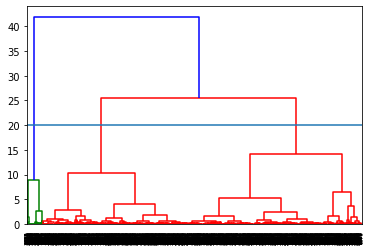

In [30]:
import scipy
from scipy.cluster import hierarchy
dendro=hierarchy.dendrogram(hierarchy.linkage(sent_vectors,method='ward'))
plt.axhline(y=20)

In [31]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')  
Agg=cluster.fit_predict(sent_vectors)

In [32]:
df_1['AVG-W2V Clus Label'] = cluster.labels_
df_1.head(2)
df_1.groupby(['AVG-W2V Clus Label'])['cleaned_text'].count()

AVG-W2V Clus Label
0    1596
1    1078
2     101
3     187
4     666
5      94
6     278
Name: cleaned_text, dtype: int64

In [33]:
for i in range(5):
    print("2 reviews of assigned to cluster ", i)
    print("-" * 70)
    print(df_1.iloc[df_1.groupby(['AVG-W2V Clus Label']).groups[i][0]]['cleaned_text'])
    print('\n')
    print(df_1.iloc[df_1.groupby(['AVG-W2V Clus Label']).groups[i][1]]['cleaned_text'])
    print('\n')
    print("_" * 70)

2 reviews of assigned to cluster  0
----------------------------------------------------------------------
veri fast shipping. product like descript


soy de venezuela el paquet llego vació. la empresa que contrat repuso el dinero en bolivares, así que perdí mi cupo de dolar el tiempo.*pendient cuando compren un articulo por el que tengan que pagar impuestos, pued que se lo roben en el trayecto.


______________________________________________________________________
2 reviews of assigned to cluster  1
----------------------------------------------------------------------
the larg screen accesibilit option help mom read text phone without glass without compromis much screen real estat


my boyfriend got phone summer, actual like much better former iphone. it come earbuds, charg cable, use charg adaptor accommod differ charg ports. i person think big, i small hand haha. overall, reliabl phone work realli well.


______________________________________________________________________
2 re

k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. we can see from the result that k-means are easy to understand than DBSCAN. The DBSCAN can control even missing values in the data set. Hierarchial clustering have lot of noise. We can say k-means are best and optimal.